In [1]:
!curl -L -o ibug-300w-large-face-landmark-dataset.zip https://www.kaggle.com/api/v1/datasets/download/toxicloser/ibug-300w-large-face-landmark-dataset
!unzip -q ibug-300w-large-face-landmark-dataset.zip
!rm -rf ibug-300w-large-face-landmark-dataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1716M  100 1716M    0     0   149M      0  0:00:11  0:00:11 --:--:--  139M


In [2]:
!mv ibug_300W_large_face_landmark_dataset/* .
!rmdir ibug_300W_large_face_landmark_dataset

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
from torchvision.transforms.functional import pil_to_tensor
import torchvision.transforms as transforms
import os
import xml.etree.ElementTree as ET
import PIL
from torchvision.transforms.functional import pil_to_tensor
import random
from tqdm import tqdm
import copy
from tqdm import tqdm
import torchvision.models as models
from torch.optim.lr_scheduler import ReduceLROnPlateau

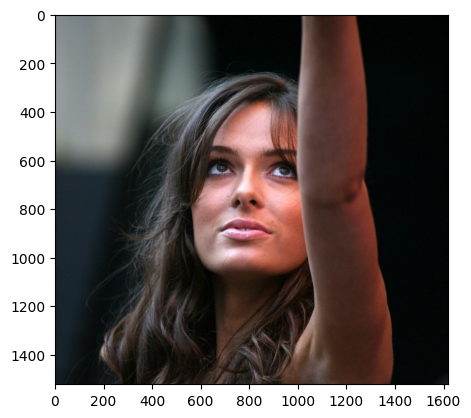

In [4]:
plt.imshow(PIL.Image.open('helen/trainset/100032540_1.jpg'))

In [ ]:
class Transofm():
    def __init__(self, do_not_transform=False):
        self.do_not_transform = do_not_transform
        pass

    def crop_img(self, img, coords, crop):
        left, right, top, bottom = crop['left'], crop['right'], crop['top'], crop['bottom']
        add_left = random.randint(0, 100)
        add_top = random.randint(0, 100)
        add_right = random.randint(0, 50)
        add_bottom = random.randint(0, 50)
        
        left = max(0, left - add_left)
        top = max(0, top - add_top)
        right = min(img.shape[2], right + add_right)
        bottom = min(img.shape[1], bottom + add_bottom)
        
        img = img[:,top:bottom,left:right]
        coords[:,0] -= left
        coords[:,1] -= top
        return img, coords

    def resize_img(self, img, coords, resize_size=(224, 224)):
        scale_x = resize_size[1] / img.shape[2]
        scale_y = resize_size[0] / img.shape[1]
        
        img = torchvision.transforms.functional.resize(img, size=resize_size)
        
        coords[:,0] = coords[:,0] * scale_x
        coords[:,1] = coords[:,1] * scale_y

        coords[:,0] /= resize_size[0]
        coords[:,1] /= resize_size[1]
        # print(coords)
        return img, coords

    def color_jitter_img(self, img):
        color_jitter = transforms.ColorJitter(contrast=random.uniform(0,0.3),
                                              saturation=random.uniform(0,0.3), 
                                              hue=random.uniform(0,0.2))
        img = color_jitter(img)
        return img

    def rorate_img(self, img, coords, angle):
        angle = random.uniform(-angle, +angle)
        # print(angle)

        transformation_matrix = torch.tensor([
            [+np.cos(np.radians(angle)), -np.sin(np.radians(angle))], 
            [+np.sin(np.radians(angle)), +np.cos(np.radians(angle))]
        ])

        img = torchvision.transforms.functional.rotate(img, angle)

        coords = coords - 0.5
        
        coords = np.matmul(coords, transformation_matrix)
        coords = coords + 0.5
        return img, coords

    
    def __call__(self, img, coords, crop):
        img_tensor = pil_to_tensor(img).float()
        assert(len(img_tensor.shape) == 3 and img_tensor.shape[0] == 3)
        coords_tensor = torch.tensor(coords, dtype=torch.float)
        img_tensor /= 255
        img_tensor, coords_tensor = self.crop_img(img_tensor, coords_tensor, crop)
        img_tensor, coords_tensor = self.resize_img(img_tensor, coords_tensor)
        
        if (self.do_not_transform == False):    
            img_tensor = self.color_jitter_img(img_tensor)
            img_tensor, coords_tensor = self.rorate_img(img_tensor, coords_tensor, angle=random.randint(-20,20))

        return img_tensor, coords_tensor

In [6]:

class MyDataset(Dataset):
    def __init__(self, file_to_parse, tranform=None, indices=None):
        tree = ET.parse(file_to_parse)
        root = tree.getroot()
        
        self.transform = tranform
        self.img_pathes = []
        self.img_box = []
        self.coords = []
        for cur in tqdm(root[2]):
            img = PIL.Image.open(cur.attrib['file'])
            if (img.mode != 'RGB'):
                continue
            if (int(cur[0].attrib['left']) < 0 or int(cur[0].attrib['top']) < 0):
                continue
            self.img_pathes.append(cur.attrib['file'])
            
            self.img_box.append({
                'left': int(cur[0].attrib['left']),
                'top': int(cur[0].attrib['top']),
                'right': int(cur[0].attrib['left']) + int(cur[0].attrib['width']),
                'bottom': int(cur[0].attrib['top']) + int(cur[0].attrib['height']),
            })
            cur_coords = []
            for i in range(68):
                cur_coords.append([int(cur[0][i].attrib['x']), int(cur[0][i].attrib['y'])])
                
            self.coords.append(cur_coords)


        self.img_pathes = np.array(self.img_pathes)
        self.coords = np.array(self.coords)
        self.img_box = np.array(self.img_box)
        
        if (indices is not None):
            self.img_pathes = self.img_pathes[indices]
            self.coords = self.coords[indices]
            self.img_box = self.img_box[indices]
            

    def __len__(self):
        return len(self.img_pathes)
        
    def __getitem__(self, idx):
        img = PIL.Image.open(self.img_pathes[idx])
        
        coords = self.coords[idx]
        if (self.transform):
            img, coords = self.transform(img, coords, self.img_box[idx])

        
        return (img, coords)

In [7]:
train_transform = Transofm()
train_dataset = MyDataset('labels_ibug_300W_train.xml', train_transform)

valid_transform = Transofm(do_not_transform=True)
valid_dataset = MyDataset('labels_ibug_300W_test.xml', valid_transform)

100%|██████████| 1008/1008 [00:00<00:00, 7747.47it/s]


In [8]:
len(train_dataset), len(valid_dataset)

(6457, 974)

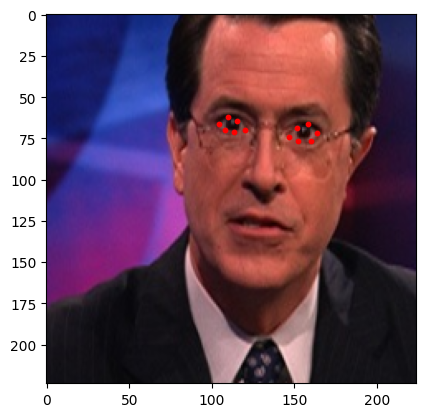

In [9]:
cur_idx=np.random.randint(0, 1000)
cur_idx=657
img, coords = valid_dataset[cur_idx]
plt.imshow(img.permute(1, 2, 0))
# print(cur_idx)
plt.scatter(coords[36:48,0]*224, coords[36:48,1]*224, s=10, c='red')

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

In [ ]:
class Resnet50Model(nn.Module):
    def __init__(self):
        super().__init__()
        resnet50 = models.resnet50(pretrained=True)
        self.conv_seq = nn.Sequential(*list(resnet50.children())[:-1])
        self.conv_seq[0] = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2048, 12*2),
        )

    def forward(self, X):
        out_resnet = self.conv_seq(X).flatten(1)
        ans = self.fc(out_resnet)
        ans = F.sigmoid(ans)
        return ans.reshape(-1, 12, 2)

In [ ]:
def train(model, criterion, optimizer, train_dataloader, valid_dataloader, epochs, device, metrics, scheduler):
    best_model = copy.deepcopy(model)
    best_loss = 1e5

    
    for epoch in range(1, epochs + 1):
        print(f'Epoch {epoch}:\n')
        model.train()
        train_loss = 0
        valid_loss = 0

        train_cnt_right = 0
        train_size = 0
        for idx, (batch_x, batch_y) in enumerate(tqdm(train_dataloader)):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device).float()[:,36:48]

            logits = model(batch_x).float()
            cur_loss = criterion(logits, batch_y)
            cur_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += cur_loss.item()
            if (idx % 30 == 0):
                metrics['train_losses'].append(train_loss / (idx + 1))
            

        model.eval()
        for batch_x, batch_y in valid_dataloader:
            with torch.no_grad():
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device).float()[:,36:48]
    
                logits = model(batch_x).float()
                cur_loss = criterion(logits, batch_y)
                valid_loss += cur_loss.item()


        train_loss /= len(train_dataloader)
        valid_loss /= len(valid_dataloader)
        print(f'Train Loss: {train_loss:.5f}\nValid Loss: {valid_loss:.5f}')
        metrics['train_losses'].append(train_loss)
        metrics['valid_losses'].append(valid_loss)
        
        if scheduler is not None:
            scheduler.step(valid_loss)
            
        if (valid_loss < best_loss):
            best_model = copy.deepcopy(model)
            best_loss = valid_loss
        
    return best_model


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

criterion = nn.MSELoss()
model = Resnet50Model().to(device)

if (device == torch.device('cuda')):
    model = nn.DataParallel(model, device_ids=['cuda:0', 'cuda:1']) 


metrics = {
    'train_losses': [],
    'valid_losses': [],
}

optimizer = torch.optim.Adam(model.module.parameters(), 1e-4)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 171MB/s]


In [14]:
best_model = train(model, criterion, optimizer, train_dataloader, valid_dataloader, 10, device, metrics, scheduler)

Epoch 1:



100%|██████████| 101/101 [04:49<00:00,  2.87s/it]


Train Loss: 0.00730
Valid Loss: 0.00257
Epoch 2:



100%|██████████| 101/101 [04:52<00:00,  2.89s/it]


Train Loss: 0.00227
Valid Loss: 0.00069
Epoch 3:



100%|██████████| 101/101 [04:51<00:00,  2.88s/it]


Train Loss: 0.00136
Valid Loss: 0.00047
Epoch 4:



100%|██████████| 101/101 [04:50<00:00,  2.88s/it]


Train Loss: 0.00105
Valid Loss: 0.00033
Epoch 5:



100%|██████████| 101/101 [04:50<00:00,  2.88s/it]


Train Loss: 0.00086
Valid Loss: 0.00025
Epoch 6:



100%|██████████| 101/101 [04:53<00:00,  2.91s/it]


Train Loss: 0.00073
Valid Loss: 0.00023
Epoch 7:



100%|██████████| 101/101 [04:51<00:00,  2.89s/it]


Train Loss: 0.00070
Valid Loss: 0.00027
Epoch 8:



100%|██████████| 101/101 [04:51<00:00,  2.88s/it]


Train Loss: 0.00062
Valid Loss: 0.00029
Epoch 9:



100%|██████████| 101/101 [04:51<00:00,  2.89s/it]


Train Loss: 0.00060
Valid Loss: 0.00032
Epoch 10:



100%|██████████| 101/101 [04:50<00:00,  2.88s/it]


Train Loss: 0.00058
Valid Loss: 0.00020


In [15]:
def plot_metrics(metrics):
    train_loss = metrics['train_losses']
    valid_loss = metrics['valid_losses']
    
    train_rmse = np.sqrt(train_loss)
    valid_rmse = np.sqrt(valid_loss)

    plt.figure(figsize=(12, 12))
    
    plt.subplot(2, 1, 1)
    plt.title("Train Loss and RMSE")
    plt.plot(train_loss, label='MSE Loss')
    plt.plot(train_rmse, label='RMSE', linestyle='--')
    plt.xticks(range(1, len(train_loss) + 1, 2))
    plt.ylabel('Loss')
    plt.xlabel('Steps')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.title("Validation Loss and RMSE")
    plt.plot(valid_loss, label='MSE Loss')
    plt.plot(valid_rmse, label='RMSE', linestyle='--')
    plt.xticks(range(1, len(valid_loss) + 1, 1))
    plt.ylabel('Loss')
    plt.xlabel('Steps')
    plt.legend()

    plt.tight_layout()
    plt.show()

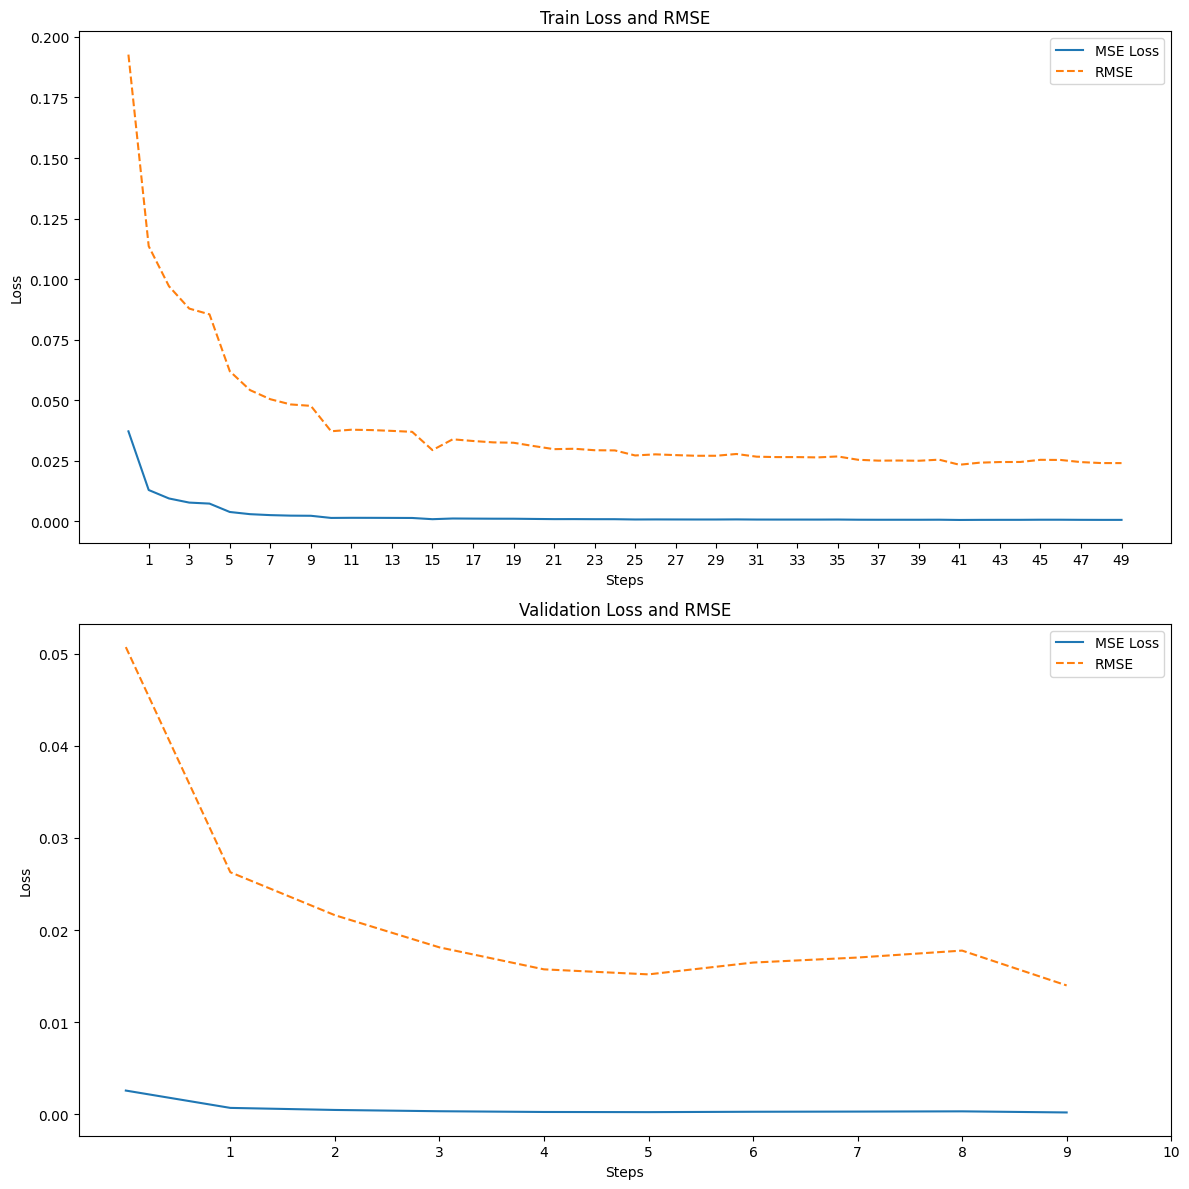

In [16]:
plot_metrics(metrics)

In [17]:
model = best_model

In [18]:
def plot_images(images, coords, real_coords):
    assert(len(images) == 4)
    plt.figure(figsize=(12, 12))
    for idx, img, crd, real_crd in zip(range(1, 5), images, coords, real_coords):
        plt.subplot(2, 2, idx)
        plt.imshow(img.permute(1, 2, 0))
        
        plt.scatter(crd[:,0] * img.shape[1], crd[:,1] * img.shape[2], s=10, c='blue')
        plt.scatter(real_crd[36:48,0] * img.shape[1], real_crd[36:48,1] * img.shape[2], s=10, c='red')

    plt.tight_layout()
    plt.show

def visualize_model(model, dataset, device, cnt=4):
    model.eval()
    idxs = np.random.choice(np.arange(len(dataset)), cnt)
    images = []
    coords = []
    real_coords = []
    for cur_idx in idxs:
        cur_img, cur_real_coords = dataset[cur_idx]
        images.append(cur_img.detach().cpu())
        real_coords.append(cur_real_coords.detach().cpu())
        
        cur_img = cur_img.unsqueeze(0).to(device)
        with torch.no_grad():
            cur_coord = model(cur_img).detach().cpu().float()

        cur_coord = cur_coord[0]

        coords.append(cur_coord)
    # print(len(real_coords), real_coords[0].shape)
    plot_images(images, coords, real_coords)

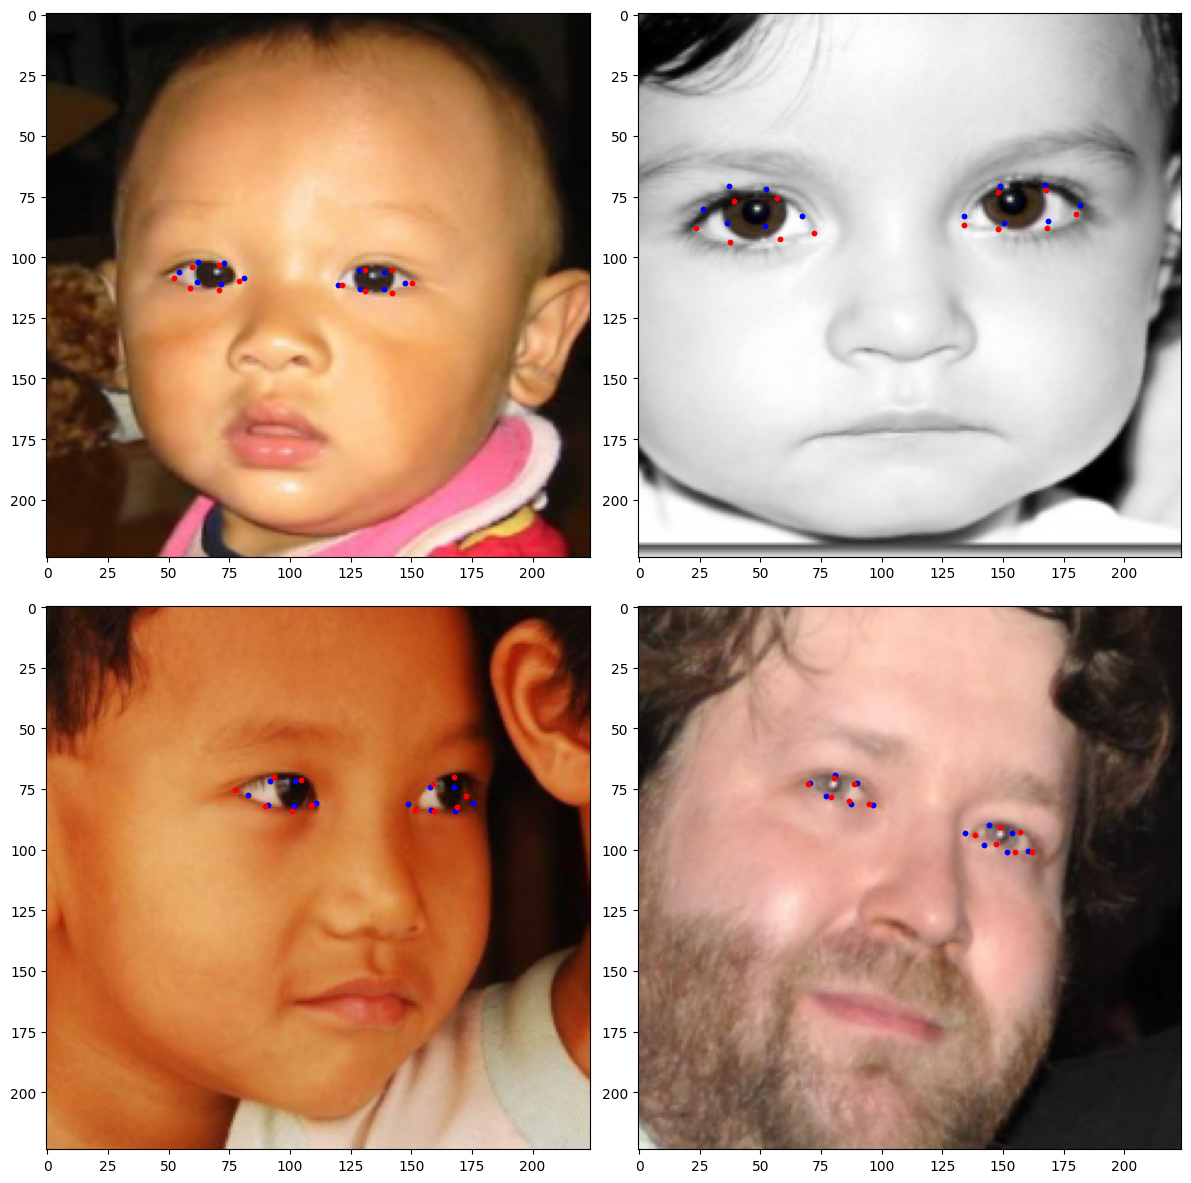

In [19]:
visualize_model(model, valid_dataset, device, 4)

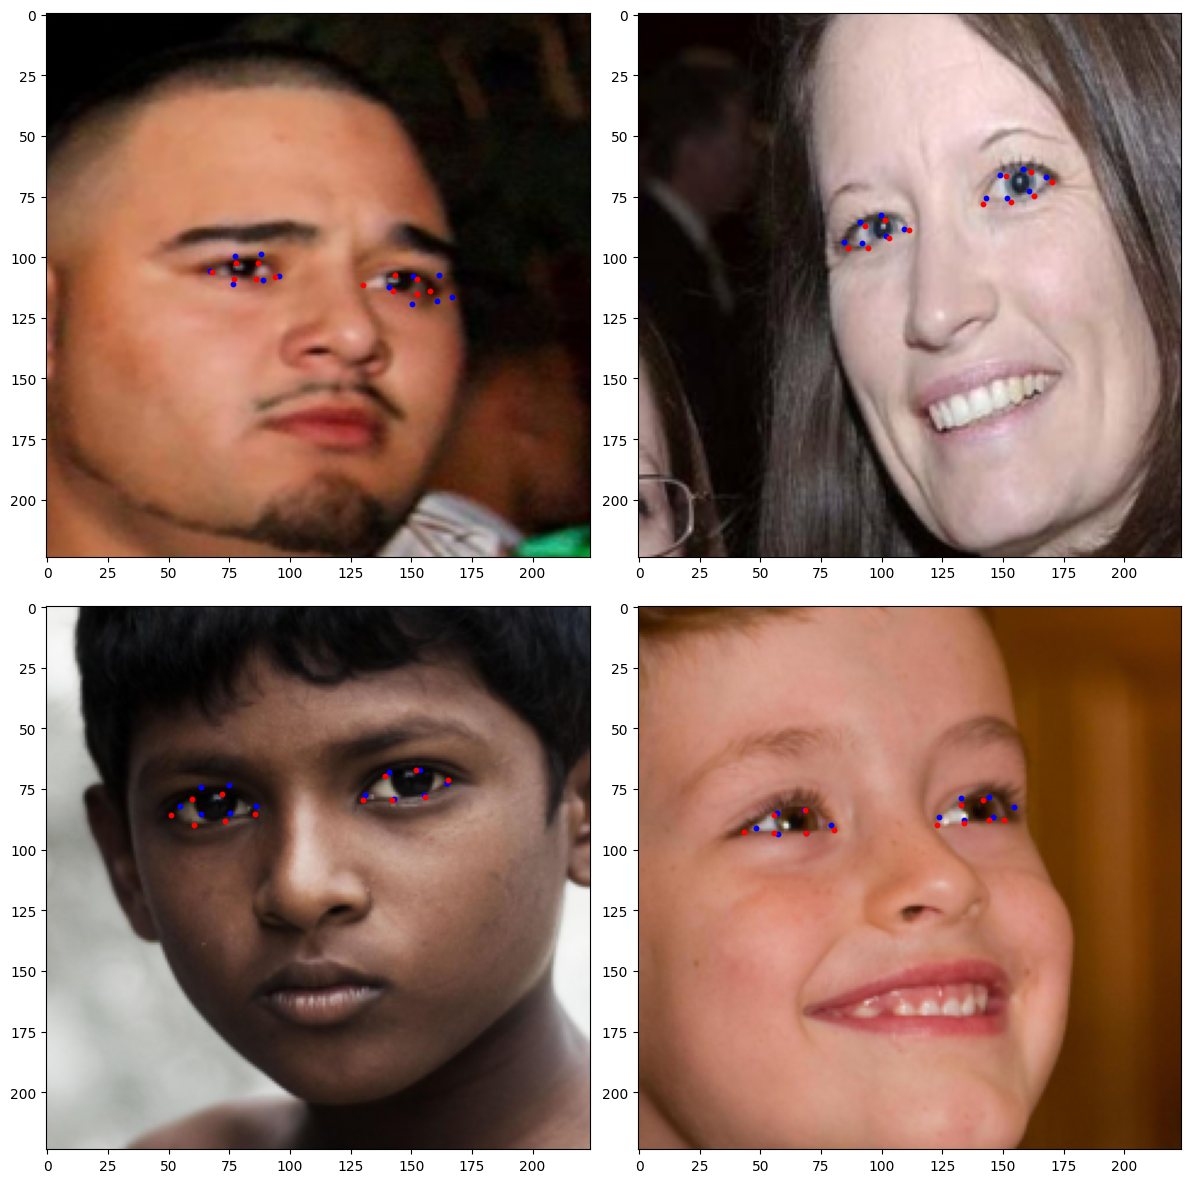

In [20]:
visualize_model(model, valid_dataset, device, 4)

In [21]:
torch.save(model.module.state_dict(), 'model.pt')

In [22]:
!ls | grep -xv model.pt | xargs rm -rf --

In [23]:
!ls

model.pt  __notebook__.ipynb
